In [49]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [36]:
import sys
sys.path.append('../../../')

from src.predictor_util import modelfit
from src.plot_utils import plot_confusion_matrix, analysing_feature_importance
from src.transformer_utils import encode_labels

## 1. Chargement du Dataset

In [37]:
df = pd.read_csv('../../../data/outputs/06_final_dataset.csv')

In [38]:
df.shape
df.head()

,grid,race_rank,points,laps,milliseconds,fastestLap,fastestLapTime,fastestLapSpeed,statusId,circuit_name,...,race_end_in_2019,race_end_in_2020,race_end_in_2021,race_end_in_2022,race_end_in_2023,driver_nber_of_races_won,driver_nber_of_times_in_top_10,constructor_races_won,constructor_avg_point,constructor_times_in_top_10
0,1,1,10.0,58,5690616,39,87452,218.300,1,Australian Grand Prix,...,21,16,21,19,12,103,283,179,3.364151,1110
1,5,2,8.0,58,5696094,41,87739,217.586,1,Australian Grand Prix,...,0,0,0,0,0,0,101,1,2.200000,91
2,7,3,6.0,58,5698779,41,88090,216.719,1,Australian Grand Prix,...,0,0,0,0,0,23,144,114,2.243008,764
3,11,4,5.0,58,5707797,58,88603,215.464,1,Australian Grand Prix,...,0,0,11,12,12,32,250,35,2.257942,390
4,3,5,4.0,58,5708630,43,87418,218.385,1,Australian Grand Prix,...,0,0,0,0,0,1,36,179,3.364151,1110


## 2. Retirer les colonnes non importantes

In [39]:
# Selection des colonnes de types objets puis suppression car le modèle ne lit pas ce type de données
cols = df.select_dtypes(np.object_).columns.to_list()
df = df.drop(cols, axis=1)

In [40]:
df.head()

,grid,race_rank,points,laps,milliseconds,fastestLap,fastestLapTime,fastestLapSpeed,statusId,constructor_is_active,...,race_end_in_2019,race_end_in_2020,race_end_in_2021,race_end_in_2022,race_end_in_2023,driver_nber_of_races_won,driver_nber_of_times_in_top_10,constructor_races_won,constructor_avg_point,constructor_times_in_top_10
0,1,1,10.0,58,5690616,39,87452,218.300,1,1,...,21,16,21,19,12,103,283,179,3.364151,1110
1,5,2,8.0,58,5696094,41,87739,217.586,1,0,...,0,0,0,0,0,0,101,1,2.200000,91
2,7,3,6.0,58,5698779,41,88090,216.719,1,1,...,0,0,0,0,0,23,144,114,2.243008,764
3,11,4,5.0,58,5707797,58,88603,215.464,1,0,...,0,0,11,12,12,32,250,35,2.257942,390
4,3,5,4.0,58,5708630,43,87418,218.385,1,1,...,0,0,0,0,0,1,36,179,3.364151,1110


## 3. Encodage des colonnes catégorielles

In [41]:
df = encode_labels(df, ['grid', 'race_rank', 'laps', 'fastestLap', 'statusId'])

## 4. Entraînement du modèle

In [42]:
target = 'race_rank'
features = [x for x in df.columns if x not in [target]]

In [43]:
# Instantiation du modèle de classification
xgb_model = xgb.XGBClassifier(
    n_estimators=205,
    learning_rate=0.001,
    max_depth=120,
    eta= 0.18,
    subsample= .8,
    colsample_bytree= 0.8,
    objective= 'multi:softmax',
    eval_metric='merror',
    min_child_weight = 9,
    gamma = 0,
    n_jobs=-1,
    num_class= 25,
    enable_categorical=True,
    seed=80,
)

In [44]:
model = modelfit(df, features, target, xgb_model)


Model Report
Accuracy : 0.3692
AUC Score (Train): 0.946202
AUC Score (Test): 0.918527


## 5. Analyse des sorties du modèle

### 5.1. Rapport de classification

In [45]:
print("Classification Report:")
print(model[4])

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       318
           1       0.93      0.87      0.90       355
           2       0.92      0.90      0.91       332
           3       0.84      0.94      0.89       327
           4       0.89      0.87      0.88       330
           5       0.80      0.77      0.79       331
           6       0.33      0.57      0.42       313
           7       0.38      0.36      0.37       337
           8       0.35      0.32      0.34       323
           9       0.35      0.36      0.35       331
          10       0.18      0.25      0.21       323
          11       0.14      0.13      0.13       343
          12       0.15      0.08      0.10       339
          13       0.11      0.09      0.10       303
          14       0.11      0.10      0.10       314
          15       0.11      0.08      0.09       346
          16       0.09      0.07      0.08       313
    

### 5.2. Matrix de Confusion

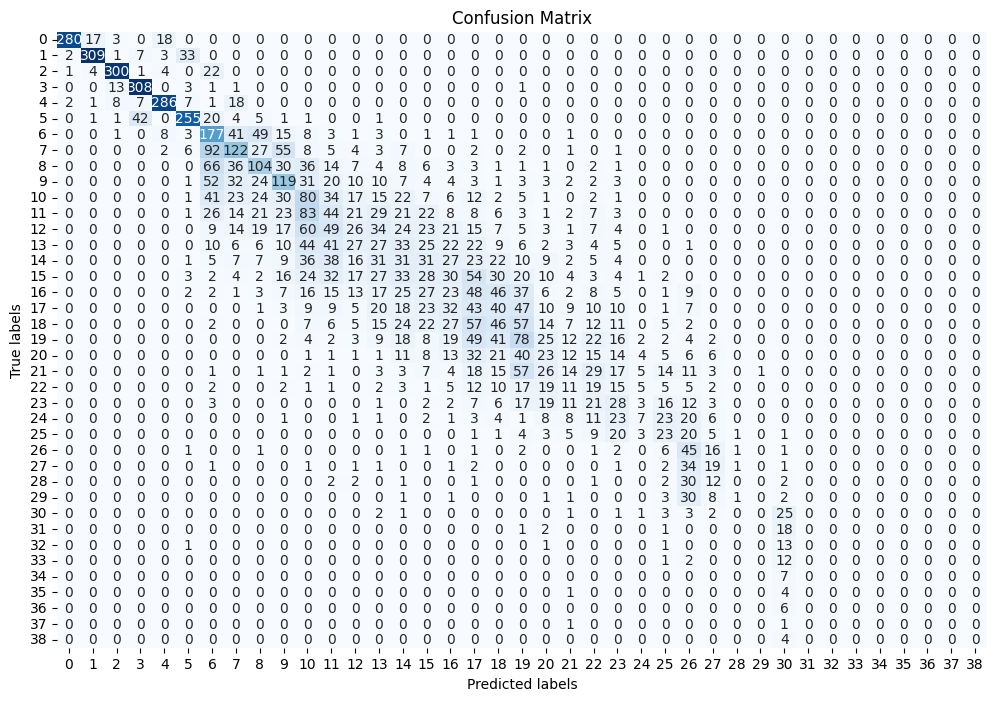

In [46]:
plot_confusion_matrix((model[1], model[2]))

### 5.3. Feature importance

In [47]:
feature_imp_serie = pd.Series(model[0].get_booster().get_fscore()).sort_values(ascending=False)

In [48]:
analysing_feature_importance(feature_imp_serie)

## 6. Boostons le model avec la validation croisée

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.30, random_state=48)

In [59]:
# Paramètre de la validation croisée
param_grid = {
    'n_estimators': [100, 200, 300],            # Nombre d'argre de XGBoost
    'max_depth': [6, 20, 75],                   # Profondeur maximal d'un arbre
    'learning_rate': [0.01, 0.05, 0.1],         # Taux d'apprentissage
    'gamma': [0, 0.1, 0.2],                     # Le minimum de perte requis pour plus de partitionnement
    'subsample': [0.6, 0.8, 1.0],               # Ke sous échantillon des instances d'entrainement
    'colsample_bytree': [0.6, 0.8, 1.0]         # Le sous échantillon de colonne lorsque l'on construit chaque arbre
}

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=50,
                                   scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1)

# Effectuons la validation croisée
random_search.fit(X_train, y_train)
#  Récupération des meilleurs paramètres et du score
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy found: ", random_search.best_score_)

# Evaluation du meilleur model en test
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy of the best model: ", test_accuracy)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best accuracy found:  0.3881469104924966
Test accuracy of the best model:  0.3945552147239264


# Conclusion

Au vue des résultats obtenus je penses que nous pouvons obtenir de meilleurs résultats en soit:
- En tratant l'équilibre des classer c'est-a dire attribuer des poids aux différentes classes
- Définir une stratégie de séparation du jeu de données sans utiliser le train_test_split
- Renforcer l'apprentissage des modèles précédents.